### This file is a playground for developing some functions and checking them before putting them in the .py files

In [116]:
# import all files from necessary directory
from os import listdir, path
dir = "/data/Riabova/train/resized_train/"
all_files = [path.join(dir, f) for f in listdir(dir)]
len(all_files)

70

In [117]:
all_files[0]

'/data/Riabova/train/resized_train/15_0_-9_0_0_0_4_2_1689849046042619.hdf5'

In [ ]:
import numpy as np
import h5py
# merge all images in one huge array

all_frames_filenames_array = np.empty((1))
frame_nums = np.empty((1))
i = 0
for f in all_files:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    h5_file = h5py.File(f, 'r')
    framesTotal = sum(item.startswith('img_') for item in list(h5_file.keys()))//11
    h5_file.close()
    all_frames_filenames_array = np.concatenate((all_frames_filenames_array, [f]*framesTotal), axis=0)
    frame_nums = np.concatenate((frame_nums, np.arange(0, framesTotal)), axis=0)
    i+=1

In [128]:
all_frames_filenames_array = all_frames_filenames_array[1:]
frame_nums = frame_nums[1:]

X = np.vstack((all_frames_filenames_array, frame_nums)).transpose()
print(X.shape)
print(X[0, :])

(951, 2)
['/data/Riabova/train/resized_train/15_0_-9_0_0_0_4_2_1689849046042619.hdf5'
 '0.0']


In [7]:
for sample in tqdm(iter(train_dataloader)):
    print(sample['image'].shape)
    break

  0%|          | 0/142 [00:00<?, ?it/s]

torch.Size([10, 1, 128, 128, 128])


### plot 3 different masks and original image next to each other

In [18]:
import h5py

maskRadius = 3

idx = 10

f = X[idx, 0]
transformNum = 10
frameNumInt = int(float(X[idx, 1]))
frameNumStr = str(frameNumInt)
h5_file = h5py.File('../train/resized_train/'+f+'.hdf5', 'r')
img = h5_file["img"+"_"+frameNumStr+"_"+str(transformNum)][()]
img2 = h5_file["img"+"_"+str(frameNumInt-2)+"_"+str(transformNum)][()]
tip_coords = h5_file["labels"+"_"+frameNumStr+"_"+str(transformNum)][()]
mask_full_2 = h5_file["mask"+"_"+str(frameNumInt-2)+"_"+str(transformNum)][()]
tip_coords_original = h5_file["labels_original"][frameNumInt, :]

mask_full = h5_file["mask"+"_"+frameNumStr+"_"+str(transformNum)][()]
mask_tip = np.zeros((img.shape))
mask_tip[np.around(tip_coords[0]-maskRadius).astype(int):np.around(tip_coords[0]+maskRadius).astype(int), 
            np.around(tip_coords[1]-maskRadius).astype(int):np.around(tip_coords[1]+maskRadius).astype(int), 
            np.around(tip_coords[2]-maskRadius).astype(int):np.around(tip_coords[2]+maskRadius).astype(int)
        ] = 1
mask_diff = mask_full - mask_full_2
h5_file.close()



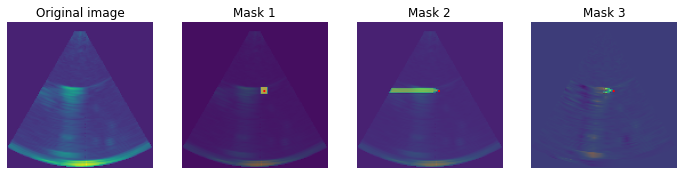

In [32]:
from matplotlib import pyplot as plt, patches

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 4, 1)
plt.imshow(img[:, :, int(tip_coords[2])].T)
ax.set_title("Original image")
plt.axis('off')


ax = fig.add_subplot(1, 4, 2)
plt.imshow(img[:, :, int(tip_coords[2])].T)
plt.imshow(mask_tip[:, :, int(tip_coords[2])].T, alpha=0.6)
ax.add_patch(patches.Circle((int(tip_coords[0]), int(tip_coords[1])), radius=0.5, color='red'))
ax.set_title("Mask 1")
plt.axis('off')


ax = fig.add_subplot(1, 4, 3)
plt.imshow(img[:, :, int(tip_coords[2])].T)
plt.imshow(mask_full[:, :, int(tip_coords[2])].T, alpha=0.6)
ax.add_patch(patches.Circle((int(tip_coords[0]), int(tip_coords[1])), radius=0.5, color='red'))
ax.set_title("Mask 2")
plt.axis('off')


ax = fig.add_subplot(1, 4, 4)
plt.imshow(img[:, :, int(tip_coords[2])].T - img2[:, :, int(tip_coords[2])].T)
plt.imshow(mask_full[:, :, int(tip_coords[2])].T-mask_full_2[:, :, int(tip_coords[2])].T, alpha=0.7)
ax.add_patch(patches.Circle((int(tip_coords[0]), int(tip_coords[1])), radius=0.5, color='red'))
ax.set_title("Mask 3")
plt.axis('off')

plt.show()

### plot two frames from one sequence next to each other with needle pixels and tip ground truth:

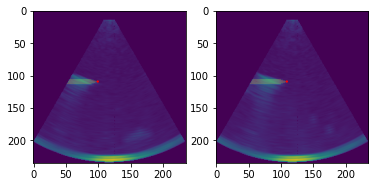

In [ ]:
import h5py
import matplotlib.pyplot as plt
from utils.type_reader import get_image_array
from matplotlib import patches


input_image = get_image_array(X[0][0])
h5_file = h5py.File('../train/needle_masks_h5/'+X[0][0][:-4].split("/")[-1]+'.hdf5', 'r')
needle_mask = h5_file['default'][()]
h5_file.close()

frame_first = 0
frame_second = 3
label_first = labels[frame_first]
label_second = labels[frame_second]

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_first[0]), int(label_first[1])), radius=1, color='red'))

ax = fig.add_subplot(1, 2, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T)
plt.imshow(needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))

plt.show()

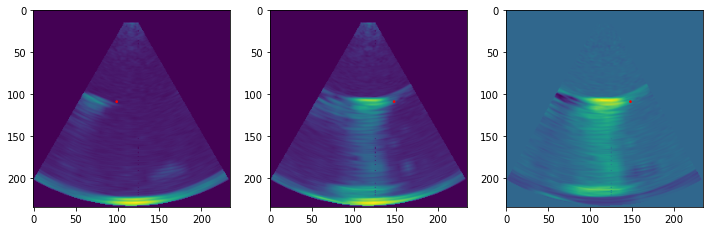

In [ ]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
#plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_first[0]), int(label_first[1])), radius=1, color='red'))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T)
#plt.imshow(needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))


ax = fig.add_subplot(1, 3, 3)
plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
#plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T-needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.3)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))
plt.show()

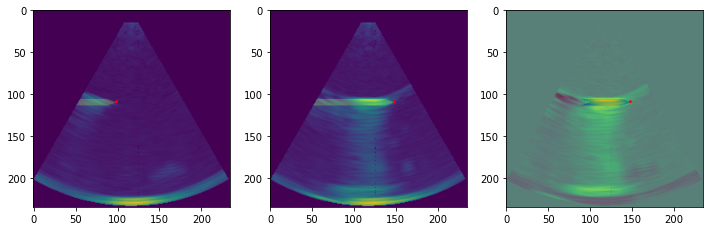

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_first[0]), int(label_first[1])), radius=1, color='red'))


ax = fig.add_subplot(1, 3, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T)
plt.imshow(needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))


ax = fig.add_subplot(1, 3, 3)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T - input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T-needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))

plt.show()

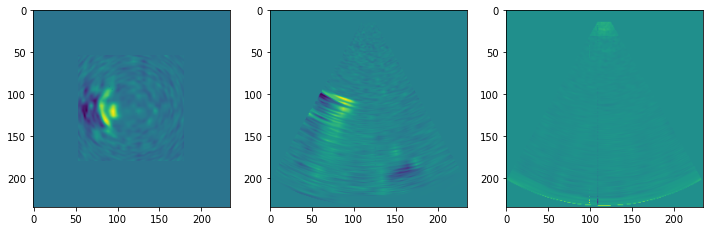

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(input_image[:, int(label_second[1]), :, frame_second].T - input_image[:, int(label_first[1]), :, frame_first].T)


ax = fig.add_subplot(1, 3, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T - input_image[:, :, int(label_first[2]), frame_first].T)



ax = fig.add_subplot(1, 3, 3)
plt.imshow(input_image[int(label_second[0]), :, :, frame_second] - input_image[int(label_first[0]), :, :, frame_first])
plt.show()

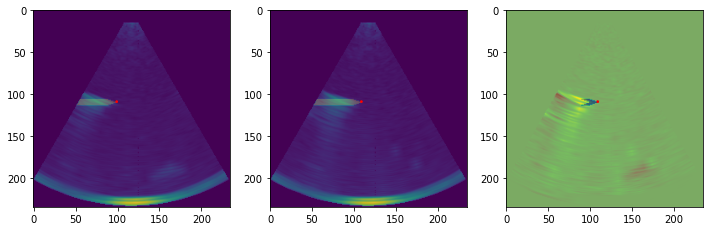

In [ ]:
frame_first = 0
frame_second = 3
label_first = labels[frame_first]
label_second = labels[frame_second]

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_first[0]), int(label_first[1])), radius=1, color='red'))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T)
plt.imshow(needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))


ax = fig.add_subplot(1, 3, 3)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T - input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T-needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.4)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))
plt.show()

### Create an animation from one sequence of images with needle pixels and tip ground truth and save it:

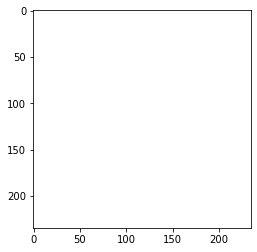

In [ ]:

import matplotlib.animation as anm

img = [] # some array of images
frames_seq = [] # for storing the generated images

fig = plt.figure()
ax = fig.add_subplot()

for i in range(needle_mask.shape[0]):
    frames_seq.append([
        plt.imshow(input_image[:, :, int(labels[i][2]), i].T), 
        plt.imshow(needle_mask[i, :, :, int(labels[i][2])].T, alpha=0.2),
        ax.add_patch(patches.Circle((int(labels[i][0]), int(labels[i][1])), radius=1, color='red'))
])

ani = anm.ArtistAnimation(fig, frames_seq)
ani.save('needle_movement.mp4')